# **FIAT Model Setup for a Road Network**

Roads are vital to the infrastructure of a community and, when blocked and/or (partially) destroyed 
cause numerous issues for various players. Therefore, it is imperative to assess the impact of loss in mobility when analyzing flood events and other hazards. 

FIAT offers a tool to compute the monetary impact of the road blockage/destruction based on the **extent of the hazard, the road type (e.g. motorway, trunk, primary roads), and the number of lanes.**

To run the FIAT model on a road network it is necessary to create the [exposure data](https://github.com/Deltares/Delft-FIAT/blob/master/docs/user_guide/data/exposure.qmd) and [vulnerability data](https://github.com/Deltares/Delft-FIAT/blob/master/docs/user_guide/data/vulnerability.qmd).

**Notebook Output**:  
The output of this notebook will be: 
- `exposure data`
- `vulnerability data` 

 which are neccessary to run the FIAT model for various events and scenarios of a flood event on a road network.


>*Note: This notebook will cover the road impact assessment based on Open Sreet Map (OSM) data.

# **Let's get started!**

# **Step 1**: Import required packages

In [1]:
# First, all required packages must be installed.

from hydromt_fiat.fiat import FiatModel
from hydromt.log import setuplog
from pathlib import Path
import geopandas as gpd
import pandas as pd
import os 
import json
import yaml
from hydromt.config import configread
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

# **Step 2:** Data Input

To run FIAT the user must provide data about the road network and the sudy area of interest;
- Polygon of the region of interest (from the coordinates we will create a shapely polygon)
- Information on the road network within the study area (geospatial file format e.g. *.shp, *.geojson, *.gpkg ):
    - road type
    - number of lanes
    - segment length
- Model configuration (see section **Step 2b: Create configuration file**) 

## **Step 2a:** Define the study area

FIAT requires the input of a region in form of a **shapely Polygon** to download the **OSM road dataset**. This can be done via **vector file** or **GeoJSON object** of the study area. We recommened to download the region from [Geojson.io](https://geojson.io/#map=2/0/20). 

**GeoJson.io**  
Draw a polygon on the map and create a polygon from the GeoJson Object. You can download a vector file, you need to refer to in the "region" tab in the *yaml* file using the file path. You can also copy the GeoJson code directly into the configuration file (see example in [configuration file](../examples/data/road_network/configuration.yaml)).

![Region](../docs/_static/charelston.svg)


In [2]:
# Create a dictionary of the GeoJson Object

region = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {},
            "geometry": {
                "type": "Polygon",
                "coordinates": [
                    [
                        [-79.96177042294748, 32.79061007407526],
                        [-79.96177042294748, 32.76748645567278],
                        [-79.91724162366485, 32.76748645567278],
                        [-79.91724162366485, 32.79061007407526],
                        [-79.96177042294748, 32.79061007407526],
                    ]
                ],
            },
        }
    ],
}

# Extract the coordinates
coordinates = region["features"][0]["geometry"]["coordinates"]

# Create a Shapely Polygon
polygon = Polygon(coordinates[0])  # Extract the coordinates of the exterior ring

## **Step 2b:** Create the configuration file

We must configure the FIAT model form of a `yaml`-file or a dictionary, in which the model parameters are defined. The configuration file must define the **vulnerability** and **exposure setup**.  
The required fields are:
  
*setup_road_vulnerability:*
- **vertical_unit**:Unit of vertical inundation (feet or meter)
- **threshold_value**: Threshold inundation height at which road is fully destroyed 
- **min_hazard_value**: minimum inundation height (recommended: 0)
- **max_hazard_value**: maximum inundation height (e.g. 6 meters) 
- **step_hazard_value**: discrete levels or steps of inundation height

*setup_exposure_roads:*
- **roads_fn**: File path to road network file or OSM data (for OSM data use: "OSM")
- **road_types**: Road type keys (if OSM data use keys from from OSM e.g. "motorway", "primary")
- **road_damage**: Damages per lane and per length unit
- **unit**: Unit of road length (feet or meter)

The provided parameters need to be incorporated into the YAML structure. Please check [here](C:/Users/rautenba/hydromt_fiat/examples/data/road_network/configuration.yaml) for the setup of the *configuration.yml*. 

### Load the configuration file

**This step is not necessary to run the model. It's just for visualization purposes.**   

The configuration file can be read in python and its information are converted into a python dictionary. </p>
<p><em>Note: Instead of loading a yaml file it is possible to create a python dictionary directly, built upon the structure seen below.</em></p>

In [3]:
# Let's read the configuration file holding the required information for the FIAT model 
with open(Path(os.path.abspath("")) / "data" / "road_network" / "configuration.yaml", 'r') as file:
    config = yaml.safe_load(file)

print(json.dumps(config, indent=4, sort_keys=False))

{
    "setup_road_vulnerability": {
        "vertical_unit": "feet",
        "threshold_value": 0.6,
        "min_hazard_value": 0,
        "max_hazard_value": 10,
        "step_hazard_value": 1
    },
    "setup_exposure_roads": {
        "roads_fn": "OSM",
        "road_types": [
            "motorway",
            "primary",
            "secondary",
            "tertiary"
        ],
        "road_damage": "default_road_max_potential_damages",
        "unit": "meter"
    }
}


# **Step 3**: <strong>Define variables for the FIAT model</strong>

To build the model some settings must be ingested as variables. So you need to set up the root path to the FIAT model, the logger settings, the region and the data catalog:
- `root`: Directory path where the FIAT model data is stored.  
- `logger`: The logger variable defines the frequencies of log-entries during the initialisation of the model.
- `region`: Define the region as a variable from the config dictionary.
- `data_catalog_yml`: Define the data catalogue as a variable from the config dictionary.



In [4]:
# Set up Fiat Model
root = Path(os.path.abspath(""))  / "data" / "road_network" /  "FIAT model" 

# Set up the logger
logger = setuplog("hydromt_fiat", log_level=10)

# Set up datacatalog
data_catalog_yml = Path(os.path.abspath("")) / "data" / "road_network" / "hydromt_fiat_catalog_USA.yml"

2024-06-28 09:09:56,775 - hydromt_fiat - log - INFO - HydroMT version: 0.8.0


# **Step 4:** Run the FIAT model

It's time to run the road network FIAT model. The output will be stored in the root-directory. 

The output will be an **exposure folder** incl. `exposure.csv` together with vector data files, a **vulnerability folder** incl. `damage_curve.csv`,  a **hazard folder** (empty) and an **output folder** (empty). 

>*Note*:  Ignore the output folder (in this notebook only)!  
 In this example we don't provide any hazard data, so the `output folder` will be empty. In case hazard data is provided the `output` folder contains an updated `exposure.csv` with the damages of the event on the road segment.

In [5]:
# Build the FIAT model 
fiat_model = FiatModel(root=root, mode="w+", data_libs=[data_catalog_yml], logger=logger)

region = gpd.GeoDataFrame.from_features(region, crs=4326)
opt = configread(Path(os.path.abspath("")) / "data" / "road_network"  /  "configuration.yaml")
fiat_model.build(region={"geom": region}, opt=opt, write=False)
fiat_model.write()

2023-11-02 09:43:10,658 - hydromt_fiat - data_catalog - INFO - Parsing data catalog from c:\Repositories\hydromt_fiat\examples\data\road_network\hydromt_fiat_catalog_USA.yml
2023-11-02 09:43:10,665 - hydromt_fiat - log - DEBUG - Writing log messages to new file c:\Repositories\hydromt_fiat\examples\data\road_network\FIAT model\hydromt.log.
2023-11-02 09:43:10,665 - hydromt_fiat - model_api - INFO - Initializing fiat model from hydromt_fiat (v0.2.1.dev0).


2023-11-02 09:43:10,688 - hydromt_fiat - model_api - INFO - setup_region.region: {'geom':                                             geometry
0  POLYGON ((-79.96177 32.79061, -79.96177 32.767...}
2023-11-02 09:43:10,689 - hydromt_fiat - basin_mask - DEBUG - Parsed region (kind=geom): {'geom': 'GeoDataFrame [-79.96177042  32.76748646 -79.91724162  32.79061007] (crs = EPSG:4326)'}
2023-11-02 09:43:10,691 - hydromt_fiat - model_api - INFO - setup_road_vulnerability.vertical_unit: feet
2023-11-02 09:43:10,692 - hydromt_fiat - model_api - INFO - setup_road_vulnerability.threshold_value: 0.6
2023-11-02 09:43:10,692 - hydromt_fiat - model_api - INFO - setup_road_vulnerability.min_hazard_value: 0
2023-11-02 09:43:10,693 - hydromt_fiat - model_api - INFO - setup_road_vulnerability.max_hazard_value: 10
2023-11-02 09:43:10,693 - hydromt_fiat - model_api - INFO - setup_road_vulnerability.step_hazard_value: 1
2023-11-02 09:43:10,694 - hydromt_fiat - model_api - INFO - setup_exposure_roads.roads_fn

INFO:hydromt_fiat:The damage function 'roads' is selected for all of the structure damage to the roads.


2023-11-02 09:43:10,792 - hydromt_fiat - data_catalog - INFO - DataCatalog: Getting default_road_max_potential_damages DataFrame csv data from c:\Repositories\hydromt_fiat\examples\data\road_network\us_road_damage.csv


INFO:hydromt_fiat:DataCatalog: Getting default_road_max_potential_damages DataFrame csv data from c:\Repositories\hydromt_fiat\examples\data\road_network\us_road_damage.csv


2023-11-02 09:43:10,796 - hydromt_fiat - dataframe - INFO - DataFrame: Read csv data.


INFO:hydromt_fiat:DataFrame: Read csv data.


2023-11-02 09:43:10,813 - hydromt_fiat - exposure_vector - INFO - Setting exposure geometries...


INFO:hydromt_fiat:Setting exposure geometries...


2023-11-02 09:43:10,814 - hydromt_fiat - exposure_vector - INFO - Setting geometry name to roads...


INFO:hydromt_fiat:Setting geometry name to roads...


2023-11-02 09:43:10,816 - hydromt_fiat - fiat - INFO - Updating all data objects...


INFO:hydromt_fiat:Updating all data objects...


2023-11-02 09:43:10,818 - hydromt_fiat - model_api - ERROR - Default config file not found at c:\Repositories\hydromt_fiat\examples\data\fiat\settings.toml


ERROR:hydromt_fiat:Default config file not found at c:\Repositories\hydromt_fiat\examples\data\fiat\settings.toml


2023-11-02 09:43:10,819 - hydromt_fiat - model_api - WARNING - Replacing geom: region


2023-11-02 09:43:10,820 - hydromt_fiat - fiat - INFO - Writing model data to c:\Repositories\hydromt_fiat\examples\data\road_network\FIAT model


INFO:hydromt_fiat:Writing model data to c:\Repositories\hydromt_fiat\examples\data\road_network\FIAT model


2023-11-02 09:43:10,821 - hydromt_fiat - model_api - INFO - Writing model config to c:\Repositories\hydromt_fiat\examples\data\road_network\FIAT model\settings.toml


INFO:hydromt_fiat:Writing model config to c:\Repositories\hydromt_fiat\examples\data\road_network\FIAT model\settings.toml


2023-11-02 09:43:10,822 - hydromt_fiat - model_api - DEBUG - Writing file exposure/region.gpkg


DEBUG:hydromt_fiat:Writing file exposure/region.gpkg


2023-11-02 09:43:11,301 - hydromt_fiat - model_api - DEBUG - Writing file exposure/roads.gpkg


DEBUG:hydromt_fiat:Writing file exposure/roads.gpkg


2023-11-02 09:43:11,327 - hydromt_fiat - fiat - INFO - Writing model exposure table file to exposure/exposure.csv.


INFO:hydromt_fiat:Writing model exposure table file to exposure/exposure.csv.


2023-11-02 09:43:11,332 - hydromt_fiat - fiat - INFO - Writing model vulnerability_curves table file to vulnerability/vulnerability_curves.csv.


INFO:hydromt_fiat:Writing model vulnerability_curves table file to vulnerability/vulnerability_curves.csv.


# **Done!**
Your **FIAT model** created the exposure and vulnerability files for the road network. Using that data in combination with a hazard map, the impact for the defined hazard can be computed. 

Let's have a look at the output!

In [24]:
# Load exposure.csv into dataframe
df_exposure = pd.read_csv(Path(os.path.abspath("")) / "data" / "road_network"  /  "FIAT model" / "exposure" / "exposure.csv")

# Load exposure geopackage into GeoDataFrame
gdf_exposure =gpd.read_file(Path(os.path.abspath("")) / "data" / "road_network" /  "FIAT model"  /  "exposure" /  "roads.gpkg")

# Merge dataframe with GeoDataFrame
merged_gdf = gdf_exposure.merge(df_exposure, left_on='Object ID', right_on='Object ID', how='inner')

# Display the road network
road_network = merged_gdf.explore(column = 'Max Potential Damage: Structure')
road_network

The vulnerability is translated into a step function, which is determined by the water level threshold.  Water levels beyond the threshold result in untraversible road segments. 

We can have a look at the `vulnerability.csv` output and the vulnerability curve. 

In [11]:
# Display vulnerability.csv 
df_vulnerability = pd.read_csv(Path(os.path.abspath("")) / "data" / "road_network"  /  "FIAT model" / "vulnerability" / "vulnerability_curves.csv")
df_vulnerability

#UNIT=feet
#METHOD                  mean
water depth [feet]      roads
0.0                       0.0
0.59                      0.0
0.6                       1.0
1.0                       1.0
2.0                       1.0
3.0                       1.0
4.0                       1.0
5.0                       1.0
6.0                       1.0
7.0                       1.0
8.0                       1.0
9.0                       1.0
10.0                      1.0

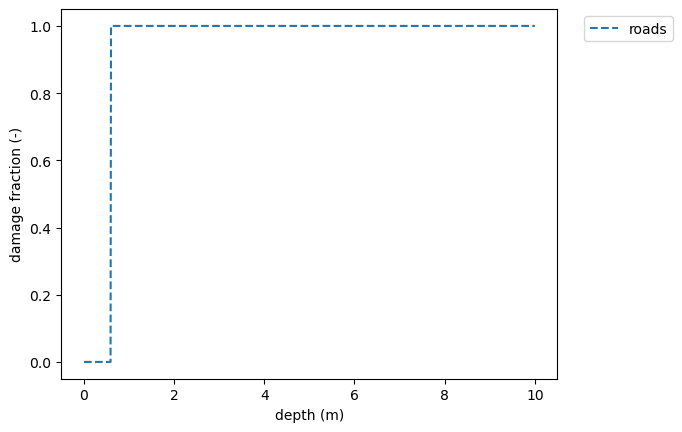

In [9]:
# Display vulnerability curves
water_depths = fiat_model.vulnerability.hazard_values

# Plot damage curves for some occupancy types
line_styles = ['--', '-', ':']
for function_name, ls in zip(fiat_model.vulnerability.functions.keys(), line_styles):
    dmg = [float(i) for i in fiat_model.vulnerability.functions[function_name]]
    plt.plot(water_depths, dmg, label=function_name, ls=ls)
plt.xlabel('depth (m)')
plt.ylabel('damage fraction (-)')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()